<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_8/8_2_DCGAN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# DCGAN on CIFAR-10

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1000)
np.random.seed(1000)
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [8]:
image_size = 32   # CIFAR-10: 32x32
nc = 3            # number of channels (RGB)
latent_dim = 100  # розмір вектора шуму
batch_size = 128

# Дані CIFAR-10
# [0,1] -> [-1,1] через Normalize((0.5,...),(0.5,...))
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))  # (x - 0.5)/0.5 -> [-1,1]
])

train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

print("Train samples:", len(train_dataset))
print("One image shape:", train_dataset[0][0].shape)  # [3, 32, 32]


Train samples: 50000
One image shape: torch.Size([3, 32, 32])


In [3]:
# Дискримінатор: 3x32x32 -> 1
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 32x32
            nn.Conv2d(nc, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 16x16
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.4),

            # 8x8
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.4),

            # 4x4
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.4),

            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()  # ймовірність "справжнє"
        )

    def forward(self, x):
        return self.net(x)


In [4]:
# Генератор: 100 -> 3x32x32
# Linear + ConvTranspose2d (upsampling 4x4 -> 8x8 -> 16x16 -> 32x32)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv = nn.Sequential(
            # 4x4 -> 8x8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # 32x32, останній шар
            nn.Conv2d(64, nc, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # вихід у [-1,1]
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 4, 4)
        x = self.conv(x)
        return x



In [5]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

criterion = nn.BCELoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002,
                         betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002,
                         betas=(0.5, 0.999))


In [6]:
#Функція для візуалізації згенерованих CIFAR-картинок
def denorm(x):
    # з [-1,1] назад у [0,1]
    return (x + 1) / 2

def plot_generated_images(epoch, generator, num_images=10):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim, device=device)
        fake = generator(z).cpu()
        fake = denorm(fake)  # [N, 3, 32, 32]

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = fake[i].permute(1, 2, 0).numpy()  # -> HWC
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Epoch: {epoch}")
    plt.tight_layout()
    plt.show()

    generator.train()


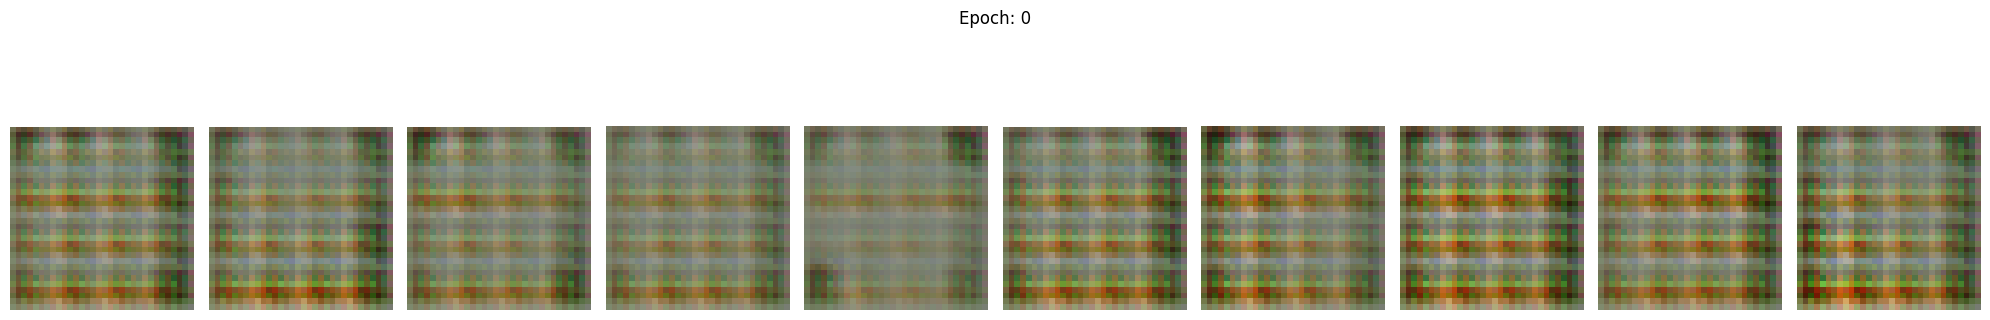

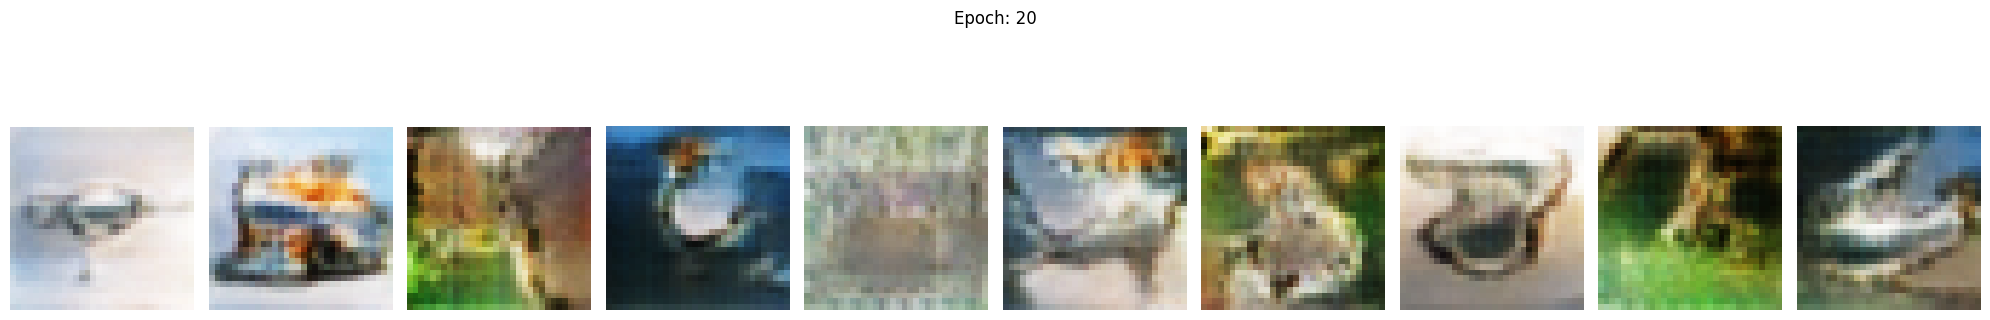

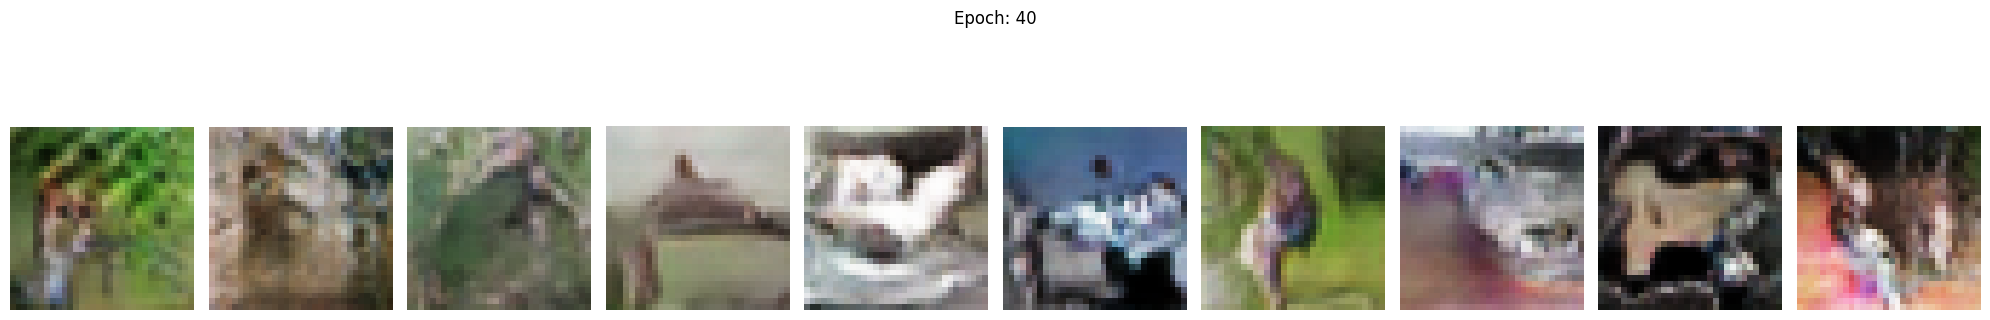

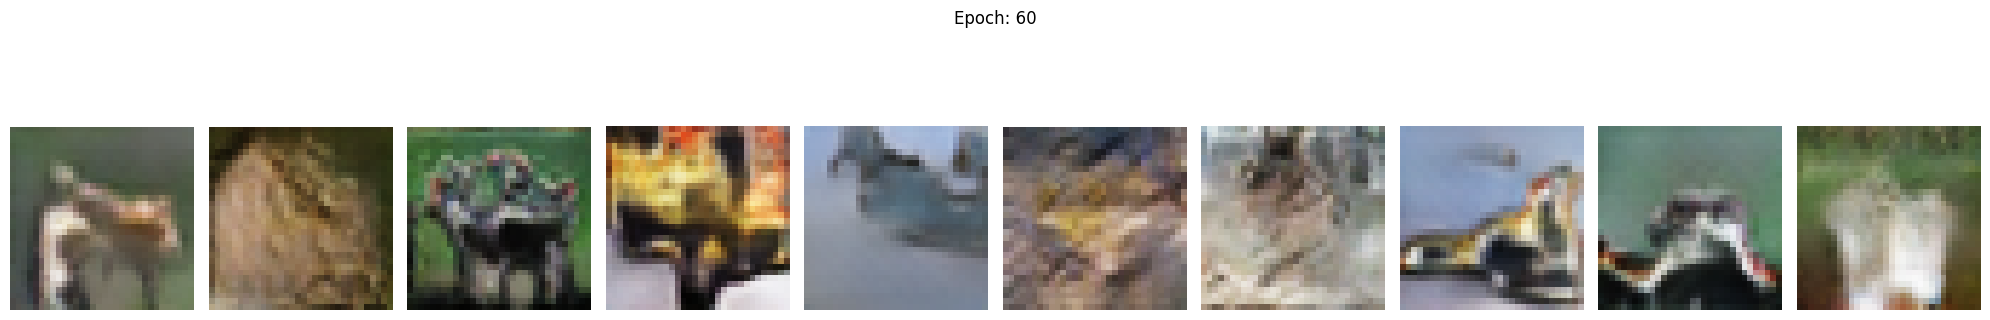

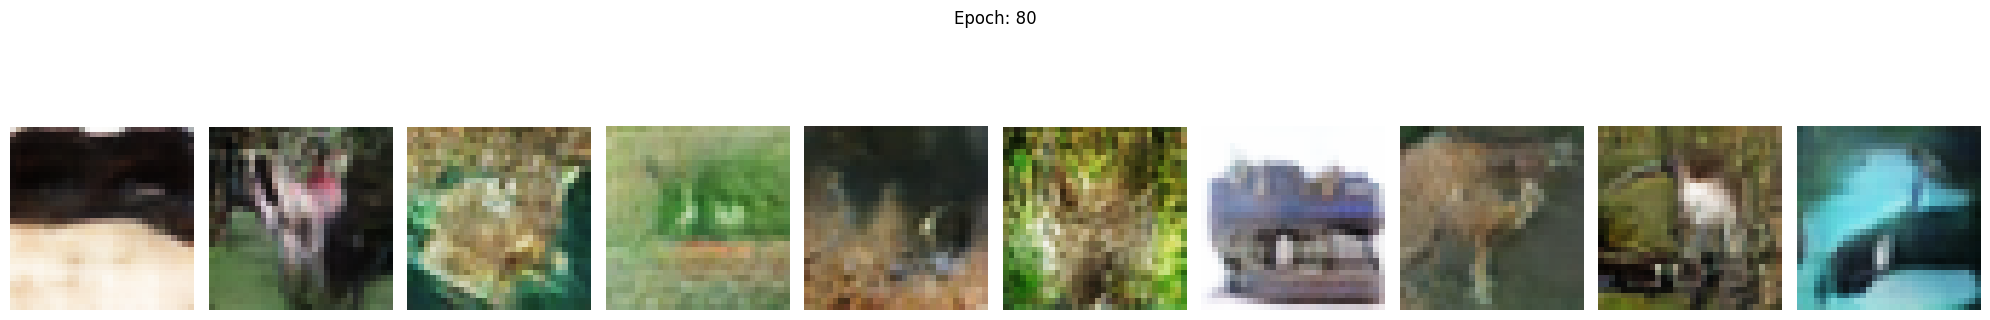

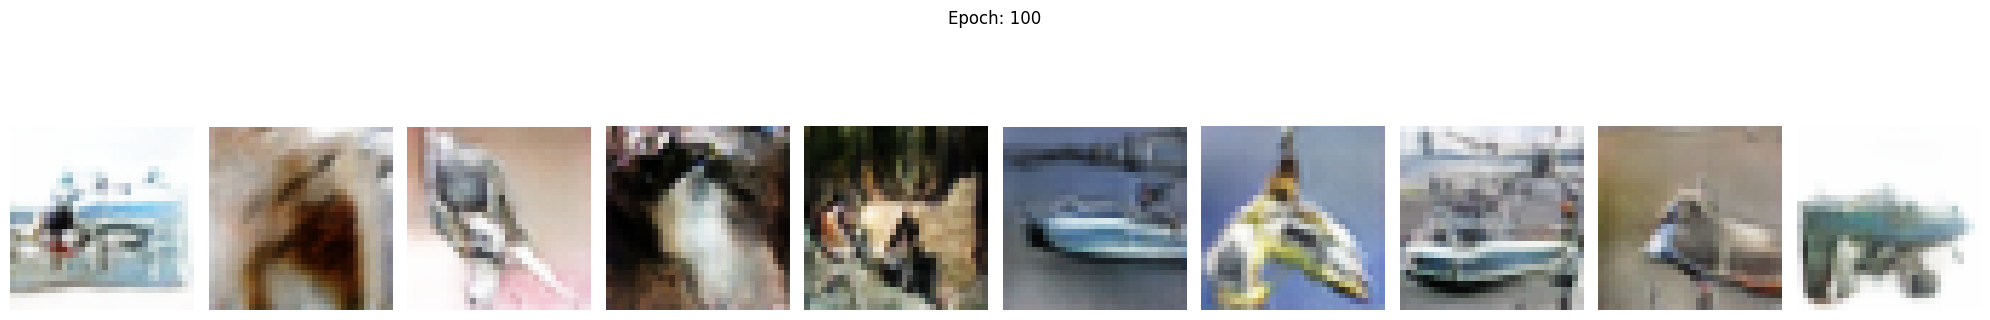

Тренування 3853.3 сек (~64.22 хв)


In [7]:
discrim_losses = []

def train_dcgan(epochs):
    for epoch in range(epochs + 1):
        for real_images, _ in train_loader:
            real_images = real_images.to(device)
            b_size = real_images.size(0)

            # Train Discriminator
            # One-sided label smoothing: 0.9 для реальних, 0.0 для фейкових
            real_labels = torch.full((b_size, 1), 0.9, device=device)
            fake_labels = torch.zeros(b_size, 1, device=device)

            # Реальні
            outputs_real = discriminator(real_images)
            d_loss_real = criterion(outputs_real, real_labels)

            # Фейкові
            z = torch.randn(b_size, latent_dim, device=device)
            fake_images = generator(z)
            outputs_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            discrim_losses.append(d_loss.item())

            # Train Generator
            # Хочемо, щоб дискримінатор вважав фейк "реальним" (label = 1)
            z = torch.randn(b_size, latent_dim, device=device)
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)  # таргет – як для реальних

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        # Кожні 20 епох — вивід
        if epoch % 20 == 0:

            plot_generated_images(epoch, generator)


epochs = 100
start_time = time.perf_counter()
train_dcgan(epochs)
end_time = time.perf_counter()
total_sec = end_time - start_time
print(f"Тренування {total_sec:.1f} сек (~{total_sec/60:.2f} хв)")

